<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/elo_2022_07_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting game results

### References

- [Fangraphs post comparing ELO with regression.](https://tht.fangraphs.com/elo-vs-regression-to-the-mean-a-theoretical-comparison/)
- [Baseball Prospectus post about ELO by Nate Silver.](https://www.baseballprospectus.com/news/article/5247/lies-damned-lies-we-are-elo/)
- [538's desciption of their ELO model](https://fivethirtyeight.com/features/how-our-mlb-predictions-work/)

#notebook setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/My Drive/mlb/modelling/models")

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('ggplot')

# load and prepare data

In [129]:
import pandas as pd
pd.set_option('display.max_columns', None)

features = pd.read_parquet(
    '/content/drive/My Drive/mlb/features/features.parquet',
    columns=['game_id', 'date', 'visitor_id', 'home_id', 'season', 'W', 'RD', 'home_rest_3', 'visitor_rest_3'])

features['delta_rest_3'] = features['home_rest_3'] - features['visitor_rest_3']

features.head(10)

,game_id,date,visitor_id,home_id,season,W,RD,home_rest_3,visitor_rest_3,delta_rest_3
0,0,1990-04-09,5,2,1990,1,3,1.000000,1.000000,0.0
1,1,1990-04-09,11,0,1990,0,-3,1.000000,1.000000,0.0
2,2,1990-04-09,23,3,1990,1,1,1.000000,1.000000,0.0
3,3,1990-04-09,8,10,1990,1,5,1.000000,1.000000,0.0
4,4,1990-04-09,14,13,1990,1,2,1.000000,1.000000,0.0
5,5,1990-04-09,18,6,1990,0,-4,1.000000,1.000000,0.0
6,6,1990-04-09,21,20,1990,1,2,1.000000,1.000000,0.0
7,7,1990-04-09,26,24,1990,0,-9,1.000000,1.000000,0.0
8,8,1990-04-09,29,28,1990,1,1,1.000000,1.000000,0.0
9,9,1990-04-10,29,28,1990,1,2,0.666667,0.666667,0.0


In [130]:
# teams are indexed 0 - 29
# (teams that changed name between seasons, e.g. MON -> WAS, are considered the same)
assert set(features['home_id'].to_list()) == {n for n in range(30)}

# EDA

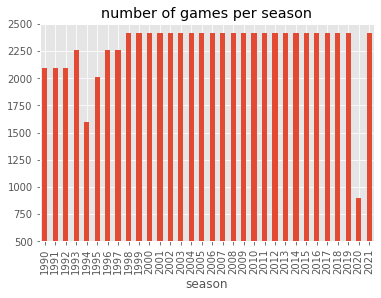

In [6]:
# the 2020 pandemic season had a low number of games
features.groupby('season')['game_id'].count().plot.bar(
    title='number of games per season',
    ylim=(500, 2500)
)

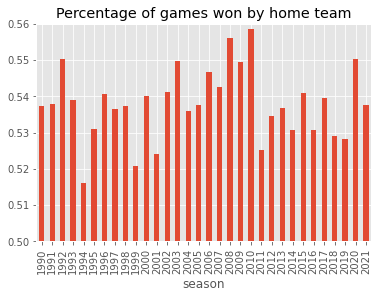

In [7]:
# the average home advantage changes from season to season
features.groupby('season')['W'].mean().plot.bar(
    title='Percentage of games won by home team',
    ylim=(.5,.56)
)

# model evaluation

In [131]:
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('ggplot')

def train(model, features, scale_yearly=0, feature_names=[]):
    """Run online training algorithm over the training data in features.

    Because training is online we use progressive validation: predictions 
    are recorded before each training step.

    Returns a dataframe containing features as well as predicted probabilities
    and the teams' rating dynamics.
    """
    cols = features.columns.to_list() + ['p', 'home_rating', 'visitor_rating']
    df = pd.DataFrame(columns=cols)
    df[features.columns] = features
    current_season = features.loc[0, 'season']
    results = []

    for i in range(len(df)):
        if df.loc[i, 'season'] > current_season:
            model.reset_weights(scale_yearly)
            current_season = df.loc[i, 'season']
        h, v = df.loc[i, 'home_id'], df.loc[i, 'visitor_id']
        feats = np.array([df.loc[i, n] for n in feature_names])
        g = Game(h, v, feats, df.loc[i, 'RD'])
        p = model.predict_proba(g)
        model.step(g, df.loc[i, 'W'])

        # log values
        h_rating = model.params.ratings[h]
        v_rating = model.params.ratings[v]

        results.append((p, h_rating, v_rating))
    
    df[['p', 'home_rating', 'visitor_rating']] = results

    df['log_loss'] = - df['W'] * np.log(df['p']) - (1 - df['W']) * np.log(1 - df['p'])

    return df

def plot_model_performance(df):
    """Plot model performance per season with respect to log loss and auc roc."""

    ll = - df.groupby('season')['log_loss'].mean()

    seasons = list(set(df['season'].to_list()))

    auc = [roc_auc_score(df.loc[df['season'] == s, 'W'], df.loc[df['season'] == s,'p']) for s in seasons]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax1 = ax.twinx()

    ax.plot(seasons, auc, 'C0-')
    ax1.plot(seasons, ll, 'C1-')

    ax.set_xlabel('season')
    ax.set_ylabel('auc', color='C0')
    ax1.set_ylabel('negative log loss', color='C1')
    ax1.grid(False)

    avg_ll = -df['log_loss'].mean()
    total_auc = roc_auc_score(df['W'], df['p'])
    ax.set_title(f'Model performance by season (avg_log_loss = {avg_ll:.2f}, roc_auc = {total_auc:.2f})')
    plt.show()
    pass

def plot_log_loss_by_week(df, seasons):
    """Plot log loss per week for the given seasons."""
    df1 = pd.merge(
        df,
        df.groupby('season')[['date']].first().rename(columns={'date': 'season_start'}),
        how='left',
        on='season'
    )

    df1['week'] = (df1['date'] - df1['season_start']).dt.days // 7

    df1 = df1.groupby(['season', 'week'], as_index=False)[['log_loss']].mean() #.pivot(index='week', columns='season', values='log_loss').reset_index()

    fig = px.line(
        df1[df1['season'].isin(seasons)],
        x="week",
        y="log_loss",
        color='season',
        title='log loss by week',
        template='ggplot2')
    fig.show()

def plot_probability_calibration(df, seasons):
    """Probability calibration plot."""

    df1 = df[df['season'].isin(seasons)]

    disp = CalibrationDisplay.from_predictions(df1['W'], df1['p'], n_bins=5, strategy='quantile')

    # disp.plot()
    return

def plot_probability_histogram(df, seasons):
    """Plot histogram of probabilities for wins and losses."""
    p_win = df.loc[(df['W'] == 1) & (df['season'].isin(seasons)), 'p']
    p_loss = df.loc[(df['W'] == 0) & (df['season'].isin(seasons)), 'p']

    plt.figure(figsize=(15,7))

    plt.hist(p_win, alpha=.7, label='win', bins=100)
    plt.hist(p_loss, alpha=.7, label='loss', bins=100)

    plt.xlabel("Model probabilities")
    plt.ylabel("Count")
    plt.title('Histogram of model probabilities')
    plt.legend(loc='upper right')
    plt.show()

    return

# model base class

In [91]:
# model.py
"""Define Model abstract base class."""
from typing import List, Dict
from abc import ABC, abstractmethod
from dataclasses import dataclass
from __future__ import annotations

from utils import save_parameters


@dataclass
class Game():
  """Representation of games."""
  home: str
  visitor: str
  features: np.ndarray=None
  run_differential: int=0

class Model(ABC):
  """Model abstract base class.

  Represents a model that predicts win probabilities
  for individual games and has an online learning
  algorithm (implemented by step).
  """
  @classmethod
  def from_params(cls, params) -> Model:
    model = cls()
    model.params = params
    return model

  @abstractmethod
  def predict_proba(self, game: Game) -> float:
    """Predict probability that home team wins."""
    pass

  @abstractmethod
  def step(self, game: Game, result: float) -> None:
    """Perform single step parameter update."""
    pass

  def save_parameters(self, bucket_name: str, params: Dict) -> None:
    """Save model parameters."""
    save_parameters(bucket_name, params)

  def train(self, schedule: List[Game], results: List[float]) -> None:
    """Train the model with game results."""
    for game, result in zip(schedule, results):
      self.step(game, result)

# basic elo model

In [101]:
# elo.py
"""Simple ELO model."""
import os
# import numpy as np
from typing import Dict
from dataclasses import dataclass

# from model import Model, Game
from utils import sigmoid, load_parameters


# def np_sigmoid(x):
#   """Numerically stable sigmoid for numpy arrays."""
#   return np.where(
#     x >= 0, 
#     1 / (1 + np.exp(-x)), 
#     np.exp(x) / (1 + np.exp(x)))


@dataclass
class ELOParams():
  """Parameters for the ELO model.
  
  a: scaling factor.
  b: y-intercept.
  ratings: regression coefficients.
  k: learning rate.
  """
  ratings: np.ndarray
  weights: np.ndarray
  a: float=log(10) / 400
  k_1: float=4
  k_2: float=.01
  b: float=0.15


class ELO(Model):
  """Simple Elo Model.

  Online logistic regression for the Bradley-Terry paired comparison model.
  Also commonly known as the Elo rating system.
  """
  def __init__(self, bucket_name: str=None):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None

  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.ratings[game.home] - self.params.ratings[game.visitor]) 
    if self.params.weights is not None:
      logit += np.dot(self.params.weights, game.features) 
    logit += self.params.b
    return sigmoid(logit)

  def step(self, game: Game, result: float) -> None:
    """Perform a single step of SGD."""
    p = self.predict_proba(game)
    self.params.ratings[game.home] += self.params.k_1 * (result - p)
    self.params.ratings[game.visitor] += self.params.k_1 * (p - result)
    if self.params.weights is not None:
      self.params.weights += self.params.k_2 * self.params.weights * (result - p)
    self.params.b += self.params.k_2 * (result - p)

  def reset_weights(self, scale):
    self.params.ratings = scale * self.params.ratings


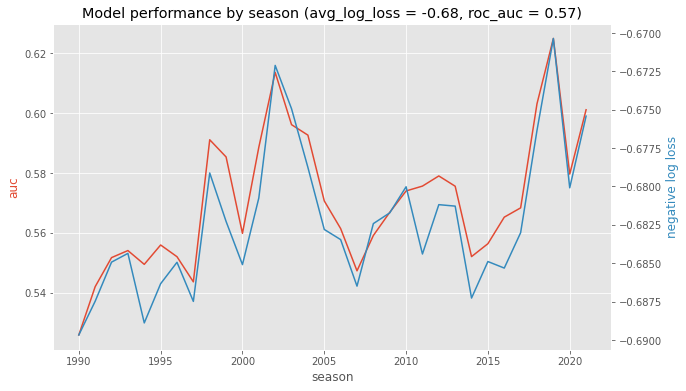

In [159]:
from math import log

params = ELOParams(**{
    'a': log(10) / 400,
    'k_1': 4,
    'b': 0.135,
    'ratings': np.zeros(30),
    'weights': np.array([0.187]),
    'k_2': 0.0
})

elo = ELO.from_params(params)

df = train(elo, features, .5, ['delta_rest_3'])

plot_model_performance(df)

In [155]:
elo.params

ELOParams(ratings=array([-16.11789572, -83.11469928,  27.44822549,  26.33515946,
        -1.34843204, -14.70620239,  39.82170585, -26.10680426,
        -7.90652597,  37.5561191 ,  17.50596652,  21.90174764,
        61.03433972, -60.68905908,  29.85840058, -71.14410234,
        31.35389356, -29.29252563,  -1.77351952, -14.84577974,
        82.86560552, -14.4246921 , -40.20130881,  33.71645792,
       -16.31511864,  -0.9216843 , -61.04586507,  69.87456548,
        31.56266707, -50.88063902]), weights=array([0.00493232]), a=0.005756462732485115, k_1=4, k_2=0.02, b=0.08917050257965278)

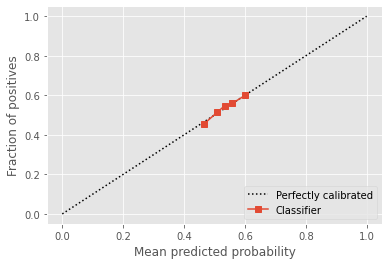

In [161]:
plot_probability_calibration(df, list(range(1990,2000)))

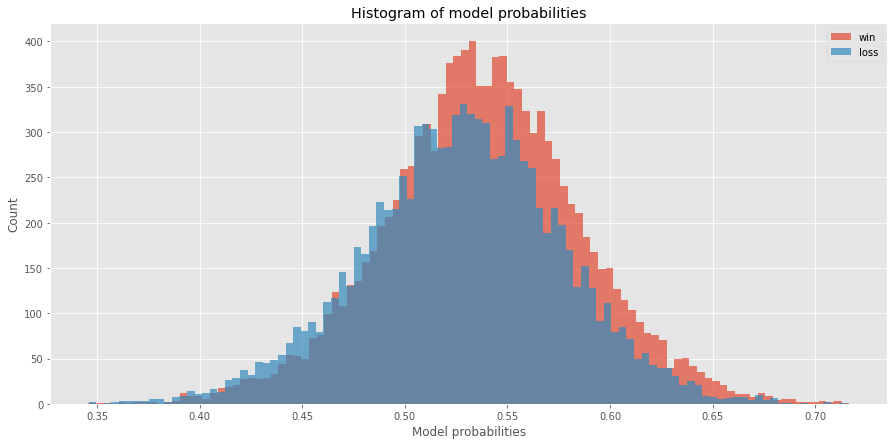

In [160]:
plot_probability_histogram(df, list(range(1990,2000)))

In [154]:
plot_log_loss_by_week(df, [2000, 2001, 2002])

In [162]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(
    solver='saga',
    random_state=42
)

X = features[features['season'] > 2010]

logistic_clf.fit(
    X[['delta_rest_3']],
    X['W']
)

logistic_clf.coef_, logistic_clf.intercept_

(array([[0.17712333]]), array([0.13584922]))

# run differential adjusted learning rate for elo model

In [88]:
# elo_ad_adjustment.py
"""Simple ELO model with run differential learning rate adjustment."""


class ELOwithRDAdjustment(ELO):
  """Simple Elo Model.

  Online logistic regression for the Bradley-Terry paired comparison model.
  Also commonly known as the Elo rating system.
  """

  def step(self, game: Game, result: float) -> None:
    """Perform a single step of SGD."""
    p = self.predict_proba(game)
    rf = log(abs(game.run_differential)) + 1
    self.params.rating[game.home] += rf * self.params.k * (result - p)
    self.params.rating[game.visitor] += rf * self.params.k * (p - result)
    self.params.b += self.params.k * (result - p) / 1000

  def reset_weights(self, scale):
    self.params.rating = scale * self.params.rating


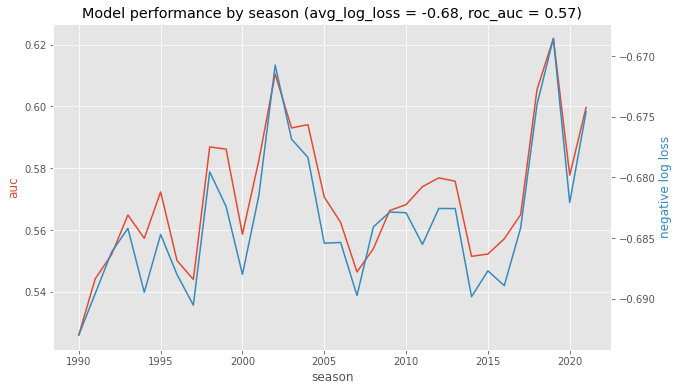

In [89]:
from math import log

params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4.5,
    'b': 0.15,
    'rating': np.zeros(30)
})

elo = ELOwithRDAdjustment.from_params(params)

df = train(elo, features, .5)

plot_model_performance(df)

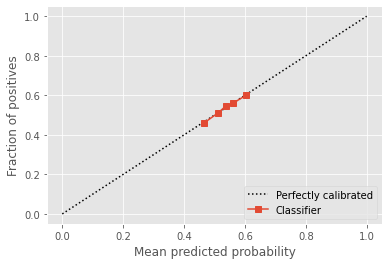

In [84]:
plot_probability_calibration(df, list(range(1990,2000)))

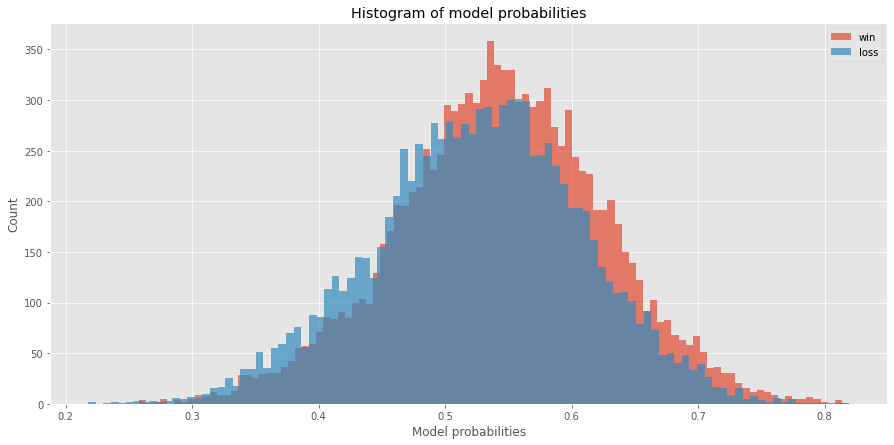

In [90]:
plot_probability_histogram(df, list(range(1990,2000)))

In [86]:
plot_log_loss_by_week(df, [2000, 2001, 2002])

# adjusted elo model

# adjusted learning rates

In [11]:
from math import sqrt

class ELOPerParameterLR(ELO):
  """Simple Elo Model.

  Online logistic regression model for Bradley-Terry paired comparison of teams.
  
  Also commonly known as the Elo rating system.

  Note: the coefficient b is not learnable in this model.
  """
  def __init__(self, bucket_name: str=None, lr=0.1):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None
    self.r = 0
    self.lr = lr

  def step(self, game: Game, result: float) -> None:
    """Perform a single step of SGD."""
    p = self.predict_proba(game)
    self.params.rating[game.home] += self.params.k * (result - p)
    self.params.rating[game.visitor] += self.params.k * (p - result)
    self.r += (p - result) ** 2
    self.params.b -= self.lr * (result - p) / (10e-7 + sqrt(self.r))


In [12]:
# adjusted_elo.py
"""Adjusted ELO model.

TO DO: add adjustments

"""
import os
from typing import Dict
from dataclasses import dataclass

# from model import Model, Game
from utils import sigmoid, load_parameters


@dataclass
class AdjustedELOParams():
  """Parameters for the ELO model.
  
  a: scaling factor.
  b: y-intercept.
  ratings: regression coefficients.
  k: learning rate.
  """
  rating: List[float]
  a: float
  k: float
  b: float


class AdjustedELO(ELO):
  """Adjusted Elo Model.

  Same as the simple Elo model but with additional adjustments to the 
  log-likelihood coming from contextual data
  (such as starting pitcher statistics).
  """
  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) 
    logit += self.params.b # add adjustments here
    return sigmoid(logit)


# bayesian ADF model

We follow the procedure for online bayesian logistic regression with assumed density filtering (ADF) described in Machine Learning: a probabilistic perspective, 18.5.3.2.





In [13]:
# bayes.py
"""Bayesian logistic regression model.

TO DO: finish writing step()

"""
import os
from typing import Dict
from dataclasses import dataclass
import numpy as np

# from model import Model, Game
from utils import sigmoid, load_parameters


def np_sigmoid(x):
  """Numerically stable sigmoid for numpy arrays."""
  return np.where(
    x >= 0, 
    1 / (1 + np.exp(-x)), 
    np.exp(x) / (1 + np.exp(x)))

@dataclass
class BayesParams():
  """Parameters for the Bayesian model.
  
  ratings: mean of regression coefficients.
  std: standard deviation of regression coefficients.
  a: scaling factor.
  b: y-intercept.
  k: learning rate.
  """
  rating: List[float]
  std: List[float]
  a: float
  k: float
  b: float


class Bayes(Model):
  """Simple Bayesian logisitic regression Model.

  Online Bayesian logistic regression model for Bradley-Terry paired comparison of teams.

  The posterior is computed by Monte-Carlo and then approximated by a Gaussian.
  """
  def __init__(self, bucket_name: str=None):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None

  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) 
    logit += self.params.b
    return sigmoid(logit)

  def sample_proba(self, game: Game, num_samples: int=1) -> float:
    """Sample likelihood that home team wins."""
    # home_rating = np.random.normal(
    #   self.params.rating[game.home],
    #   self.params.std[game.home],
    #   num_samples)
    # visitor_rating = np.random.normal(
    #   self.params.rating[game.visitor],
    #   self.params.std[game.visitor],
    #   num_samples)
    # logit = self.params.a * (home_rating - visitor_rating) 
    # logit += self.params.b
    # return np_sigmoid(logit)

  def step(self, game: Game, result: float) -> None:
    """Update posterior."""
    #p = self.sample_proba(game, 5_000)

    # compute posterior mean and standard deviation

    self.params.rating[game.home] =
    self.params.std[game.home] = 
    self.params.rating[game.visitor] =
    self.params.std[game.visitor] =

  def reset_weights(self, scale):
    self.params.rating = [x * scale for x in self.params.rating]
    self.params.std = 30 * [1]


SyntaxError: ignored

# glicko